## Классические алгоритмы без ансамблирования
В этом ноутбуке вам нужно обучить модели на датасете классификации из предыдущего ноутбука и сравнить результаты. Вам будет предоставлен baseline, на основе которого вы будете доделывать предсказывающие модели. Оценка лабы будет зависеть от ROC-AUC на тестовых данных по следующим критериям:
\
AUC - на тестовых данных
- $AUC \leq 0.75$ - 0 баллов
- $0.75 < AUC \leq 0.76$ - 2 балла
- $0.76 < AUC \leq 0.77$ - 4 балла
- $0.77 < AUC \leq 0.78$ - 6 баллов
- $0.78 < AUC \leq 0.79$ - 8 баллов
- $AUC > 0.79$ - 10 баллов

\
В этой работе запрещено использовать ансамбли моделей (лес, бустинги и т.д.)!

In [139]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import pandas as pd
import matplotlib.pyplot as plt

In [140]:
data = pd.read_csv('german.csv', sep=';')
print(data.head())

X = data.drop('Creditability', axis=1)
y = data['Creditability']

# Автоматическое определение категориальных и числовых признаков
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Создание преобразователей
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Точечный препроцессинг
# Для логистической регрессии
lr_preprocessor = ColumnTransformer([
    ('num', RobustScaler(), X.select_dtypes(include=['number']).columns),
    ('cat', OneHotEncoder(drop='first'), X.select_dtypes(include=['object']).columns)
])

# Для дерева
tree_preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), X.select_dtypes(include=['object']).columns)],
    remainder='passthrough'
)

# Для KNN
knn_preprocessor = ColumnTransformer([
    ('num', RobustScaler(), X.select_dtypes(include=['number']).columns),
    ('cat', OneHotEncoder(drop='first'), X.select_dtypes(include=['object']).columns)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

   Creditability  Account_Balance  Duration_of_Credit_monthly  \
0              1                1                          18   
1              1                1                           9   
2              1                2                          12   
3              1                1                          12   
4              1                1                          12   

   Payment_Status_of_Previous_Credit  Purpose  Credit_Amount  \
0                                  4        2           1049   
1                                  4        0           2799   
2                                  2        9            841   
3                                  4        0           2122   
4                                  4        0           2171   

   Value_Savings_Stocks  Length_of_current_employment  Instalment_per_cent  \
0                     1                             2                    4   
1                     1                             3               

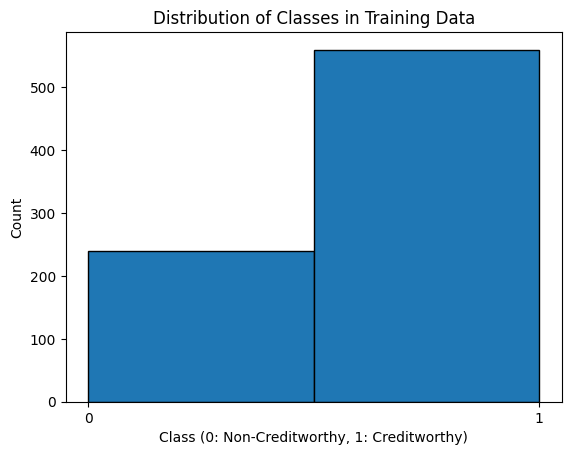

In [141]:
plt.hist(y_train, bins=2, edgecolor='k')
plt.xticks([0, 1])
plt.xlabel('Class (0: Non-Creditworthy, 1: Creditworthy)')
plt.ylabel('Count')
plt.title('Distribution of Classes in Training Data')
plt.show()

In [142]:
# Создание модели Logistic Regression
logistic_regression_model = Pipeline([
        ('pre', lr_preprocessor),
        ('model', LogisticRegression(
            class_weight='balanced',
            C=0.01,
            solver='saga',
            max_iter=2000,
            random_state=42
        ))
    ])
logistic_regression_model.fit(X_train, y_train)

# Создание модели Decision Tree
decision_tree_model = Pipeline([
        ('pre', tree_preprocessor),
        ('model', DecisionTreeClassifier(
            max_depth=9,
            min_samples_leaf=8,
            class_weight={0: 1.5, 1: 1},
            max_features=0.6,
            criterion='entropy',
            ccp_alpha=0.005,
            min_impurity_decrease=0.002,
            random_state=42
        ))
    ])
decision_tree_model.fit(X_train, y_train)

# Создание модели K-Nearest Neighbors
knn_model = Pipeline([
        ('pre', knn_preprocessor),
        ('model', KNeighborsClassifier(
            n_neighbors=45,
            weights='distance',
            metric='manhattan',
            leaf_size=30
        ))
    ])
knn_model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  Index(['Account_Balance', 'Duration_of_Credit_monthly',
       'Payment_Status_of_Previous_Credit', 'Purpose', 'Credit_Amount',
       'Value_Savings_Stocks', 'Length_of_current_employment',
       'Instalment_per_cent', 'Sex_Marital_Status', 'Guarantors',
       'Duration_in_Current_address', 'Most_valuable_available_asset',
       'Age_years', 'Concurrent_Credits', 'Type_of_apartment',
       'No_of_Credits_at_this_Bank', 'Occupation', 'No_of_dependents',
       'Telephone', 'Foreign_Worker'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index([], dtype='object'))])),
                ('model',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=45,
                                      weights='distance'))])

In [143]:
y_prob_logistic = logistic_regression_model.predict_proba(X_test)[:, 1]
y_prob_decision_tree = decision_tree_model.predict_proba(X_test)[:, 1]
y_prob_knn = knn_model.predict_proba(X_test)[:, 1]

y_pred_logistic = logistic_regression_model.predict(X_test)
y_pred_decision_tree = decision_tree_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)

accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

roc_auc_logistic = roc_auc_score(y_test, y_prob_logistic)
roc_auc_decision_tree = roc_auc_score(y_test, y_prob_decision_tree)
roc_auc_knn = roc_auc_score(y_test, y_prob_knn)

precision_logistic = precision_score(y_test, y_pred_logistic)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree)
precision_knn = precision_score(y_test, y_pred_knn)

recall_logistic = recall_score(y_test, y_pred_logistic)
recall_decision_tree = recall_score(y_test, y_pred_decision_tree)
recall_knn = recall_score(y_test, y_pred_knn)

print(f'Accuracy of Logistic Regression: {accuracy_logistic}')
print(f'Accuracy of Decision Tree: {accuracy_decision_tree}')
print(f'Accuracy of K-Nearest Neighbors: {accuracy_knn}\n')

print(f'ROC AUC of Logistic Regression: {roc_auc_logistic}')
print(f'ROC AUC of Decision Tree: {roc_auc_decision_tree}')
print(f'ROC AUC of K-Nearest Neighbors: {roc_auc_knn}\n')

print(f'Precision of Logistic Regression: {precision_logistic}')
print(f'Precision of Decision Tree: {precision_decision_tree}')
print(f'Precision of K-Nearest Neighbors: {precision_knn}\n')

print(f'Recall of Logistic Regression: {recall_logistic}')
print(f'Recall of Decision Tree: {recall_decision_tree}')
print(f'Recall of K-Nearest Neighbors: {recall_knn}\n')

Accuracy of Logistic Regression: 0.74
Accuracy of Decision Tree: 0.71
Accuracy of K-Nearest Neighbors: 0.74

ROC AUC of Logistic Regression: 0.8036904761904762
ROC AUC of Decision Tree: 0.7501785714285715
ROC AUC of K-Nearest Neighbors: 0.8045238095238094

Precision of Logistic Regression: 0.8728813559322034
Precision of Decision Tree: 0.8306451612903226
Precision of K-Nearest Neighbors: 0.7315789473684211

Recall of Logistic Regression: 0.7357142857142858
Recall of Decision Tree: 0.7357142857142858
Recall of K-Nearest Neighbors: 0.9928571428571429



## Экспериментируйте
Для получения лучшего качества придется поэкспериментировать. Подсказка: попробуйте оптимизировать гиперпараметры модели